#### Best Model

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime, os
import tensorflow as tf

from imutils import paths
import os
import shutil
import random
import filecmp

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array

import itertools    

from sklearn.metrics import confusion_matrix

In [2]:
# Installs
!pip install imutils
!pip install opencv-python

#### Extract data from the following source and save to `grid_version.tar`

In [3]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"

--2022-04-13 13:29:47--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2022-04-13 13:29:47--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5b6d9ba3eb8e41441275b2b07.dl.dropboxusercontent.com/cd/0/inline/BjUR25aoRPIFUV_3P0KOTbrEeCnJjSFKT5vfQcpyVH4cytfe8mqSt_JNVCnR3tx6rxtmcbVgu3zf-_VSNY2SZk3U4ugxG9_HN5hX5M3SLNbug5gsMqYr6RuzPi9jWpBvy2j6-ex-AggVdyFUcI1sQPmyOyCxrW7kHxv4DAyVyorJ-g/file# [following]
--2022-04-13 13:29:47--  https://uce5b6d9ba3eb8e41441275b2b07.dl.dropboxusercontent.com/cd/0/inline/BjUR25aoRPIFUV_3P0KOTbrEeCnJjSFKT5vfQcpyVH4cytfe8mqSt_JN

#### Unzip data to `grid_version` directory

In [4]:
!tar -xvf 'grid_version.tar'

grid_version/
grid_version/validate/
grid_version/.DS_Store
grid_version/train/
grid_version/train/grid_no_smoke/
grid_version/train/.DS_Store
grid_version/train/grid_smoke/
grid_version/train/grid_smoke/1529002100_+01140_05_03.png
grid_version/train/grid_smoke/1529003240_+02280_05_03.png
grid_version/train/grid_smoke/1499547403_+01140_03_06.png
grid_version/train/grid_smoke/1499547763_+01500_05_07.png
grid_version/train/grid_smoke/1529002880_+01920_05_03.png
grid_version/train/grid_smoke/1528759446_+02040_06_08.png
grid_version/train/grid_smoke/1528759506_+02100_06_04.png
grid_version/train/grid_smoke/1498418253_+01860_05_08.png
grid_version/train/grid_smoke/1498418493_+02100_04_09.png
grid_version/train/grid_smoke/1529001560_+00600_06_04.png
grid_version/train/grid_smoke/1499547283_+01020_04_06.png
grid_version/train/grid_smoke/1528759686_+02280_05_06.png
grid_version/train/grid_smoke/1529022805_+02100_05_05.png
grid_version/train/grid_smoke/1530740065_+01020_04_07.png
grid_version/t

#### Split the data randomly into `sampled_train`, `sampled_validate`, and `testing` directories

In [5]:
def split_data(directory, validate_directory='validation', split_train=0.85, split_validate=0.1): 
    directories = [os.path.join(directory, o) for o in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory,o))]
    print(directories)
    
    # create file path variables
    new_train_dir = './sampled_train'
    new_val_dir = './sampled_validate'
    testing_dir = './testing'
    
    # remove existing directories
    if os.path.isdir(new_train_dir) is True:
        shutil.rmtree(new_train_dir)
        shutil.rmtree(new_val_dir)
        shutil.rmtree(testing_dir)
    
    # create empty directories
    os.makedirs(new_train_dir)
    os.makedirs(new_val_dir)
    os.makedirs(testing_dir)
    
    for directory in directories:
        image_paths = list(paths.list_images(directory))
    
        random.seed(32)
        random.shuffle(image_paths)
        image_paths

        # compute the train, validate, and testing split
        i = int(len(image_paths) * split_train)
        j = int(len(image_paths) * split_validate)
        
        train_paths = image_paths[:i]
        selected_for_validation_paths = image_paths[i:i+j]
        test_paths = image_paths[i+j:]

        for path in selected_for_validation_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(new_val_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)

        for path in train_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(new_train_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)  
            
        for path in test_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(testing_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)  

In [6]:
split_data(directory='grid_version/train/', validate_directory='grid_version/validation')  

['grid_version/train/grid_no_smoke', 'grid_version/train/grid_smoke']


In [7]:
# Save newly generate file paths as variables

train_path = 'sampled_train'
validate_path = 'sampled_validate'
testing_path = 'testing'

#### Image Augmentation

Image augmentation is used to enhance the size and quality of training datasets for the purpose of creating more accurate Deep Learning models. Image augmentation algorithms vary in how the types of augmentation or transformations take place. Some of the methods include geometric transformations, color space augmentations, kernel filters, feature space augmentation, and so on. 

Many of the approaches used in this model were derived from the following source: (https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) 

---

**Definitions of Methods Applied**

**preprocessing_function** = preprocess_input will convert the input images from RGB to BGR, \
then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

**rescale** = re-scales image

**shear_range** = Shear transformation slants the shape of the image. This is different from rotation \
in the sense that in shear transformation, we fix one axis and stretch the image at a certain angle \
known as the shear angle. This creates a sort of ‘stretch’ in the image, which is not seen in rotation. \
shear_range specifies the angle of the slant in degrees.

**zoom_range** = A random zoom is obtained by the zoom_range argument. \
A zoom less than 1.0 magnifies the image, while a zoom greater than 1.0 zooms out of the image.

**horizontal_flip** = The generator will generate images, which on a random basis, will be horizontally flipped.


vgg16 is preprocessing is distorting color. Subtract mean RGB value, computed on training set, from each pixel.
- Find mean green pixel value for entire image, then subtract that mean value from each green pixel in image
- Find mean red pixel value for entire image, then subtract that mean value from each red pixel in image
- Find mean blue pixel value for entire image, then subtract that mean value from each blue pixel in image

In [8]:
# Apply image augmentation
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
    
validate_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. /255
)

testing_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. /255
)

In [32]:
# Variables for model
batch_size = 64
image_width = 256 
image_height = 256 
input_shape = (image_width, image_height, 3)
classes = ['grid_no_smoke','grid_smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

# Create 'train_generator' flowing from `grid_version/train` directory
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
# Create 'validate_generator' flowing from `grid_version/validate` directory
validate_generator = validate_image_generator.flow_from_directory(
        validate_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

# Create 'testing_generator' flowing from `grid_version/validate` directory
# Shuffle = False, to ensure we know the labels for predictions
testing_generator = testing_image_generator.flow_from_directory(
        testing_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode,
        shuffle=False)

Found 3077 images belonging to 2 classes.
Found 361 images belonging to 2 classes.
Found 183 images belonging to 2 classes.


#### Remove unwanted .ipynb files in `testing` directory

In [33]:
def remove_files(directory, file_type):
    list_dir = os.listdir(directory)
    
    for item in list_dir:
        if item.endswith(file_type):
            os.remove(os.path.join(directory, item))
        return f"File with extension '{file_type}' not found in {directory}"

In [34]:
remove_files('testing/grid_smoke/', '.ipynb_checkpoints'), remove_files('testing/grid_no_smoke/', '.ipynb_checkpoints')

("File with extension '.ipynb_checkpoints' not found in testing/grid_smoke/",
 "File with extension '.ipynb_checkpoints' not found in testing/grid_no_smoke/")

#### Evaluate if data leakage is present
Check if there are any identical images between the `sampled_train` and `sampled_validate` directories

In [35]:
# grid_smoke directories
val_smoke = 'sampled_validate/grid_smoke/'
train_smoke = 'sampled_train/grid_smoke/'

# grid_no_smoke directories
val_no_smoke = 'sampled_validate/grid_no_smoke/'
train_no_smoke = 'sampled_train/grid_no_smoke/'

In [37]:
def compare_directories(dir1, dir2):
    directory_cmp = filecmp.dircmp(a=dir1, b=dir2)
    print(f"Comparing {dir1.upper()} to {dir2.upper()}")
    print()
    print("Identical Files: {}".format(directory_cmp.same_files))
    print("===" * 25)
    
compare_directories(val_smoke, train_smoke), compare_directories(val_no_smoke, train_no_smoke)

Comparing SAMPLED_VALIDATE/GRID_SMOKE/ to SAMPLED_TRAIN/GRID_SMOKE/

Identical Files: []
Comparing SAMPLED_VALIDATE/GRID_NO_SMOKE/ to SAMPLED_TRAIN/GRID_NO_SMOKE/

Identical Files: []


(None, None)

#### Plot out a sample of images

In [38]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow((img * 255).astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

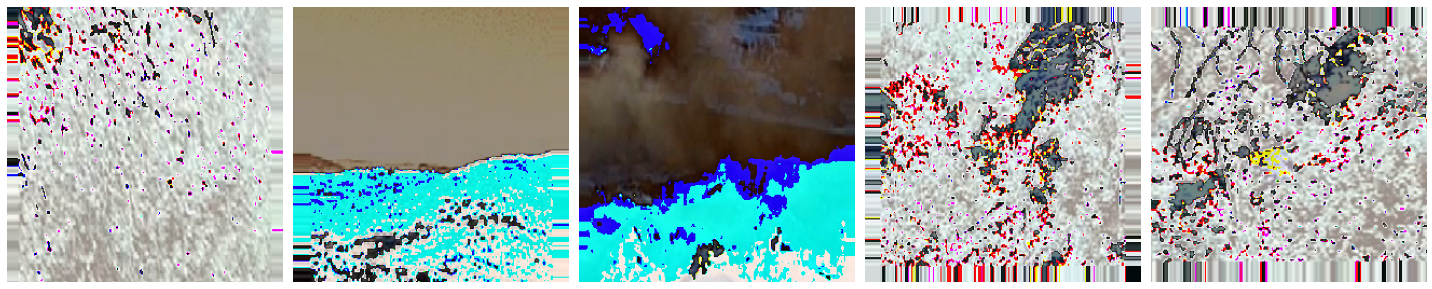

In [39]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:100])

### Neural Network

In [40]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validate_steps = validate_generator.n // validate_generator.batch_size

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validate_generator,
      validation_steps=validate_steps,
      epochs=epochs,
)

Epoch 1/10
48/48 [==============================] - 122s 3s/step - loss: 0.3189 - accuracy: 0.8410 - val_loss: 0.2456 - val_accuracy: 0.9125
Epoch 2/10
48/48 [==============================] - 117s 2s/step - loss: 0.1483 - accuracy: 0.9442 - val_loss: 0.0747 - val_accuracy: 0.9781
Epoch 3/10
48/48 [==============================] - 117s 2s/step - loss: 0.0926 - accuracy: 0.9725 - val_loss: 0.0472 - val_accuracy: 0.9906
Epoch 4/10
48/48 [==============================] - 117s 2s/step - loss: 0.0687 - accuracy: 0.9784 - val_loss: 0.0617 - val_accuracy: 0.9812
Epoch 5/10
48/48 [==============================] - 117s 2s/step - loss: 0.0674 - accuracy: 0.9784 - val_loss: 0.0652 - val_accuracy: 0.9688
Epoch 6/10
48/48 [==============================] - 117s 2s/step - loss: 0.0495 - accuracy: 0.9854 - val_loss: 0.0720 - val_accuracy: 0.9719
Epoch 7/10
48/48 [==============================] - 119s 2s/step - loss: 0.0523 - accuracy: 0.9831 - val_loss: 0.0407 - val_accuracy: 0.9844
Epoch 8/10
48

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

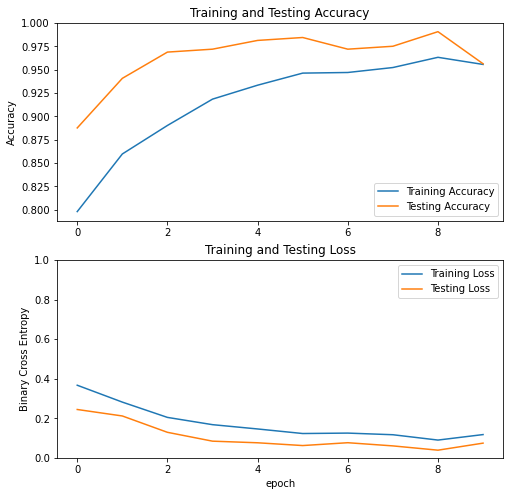

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch');

#### Predictions

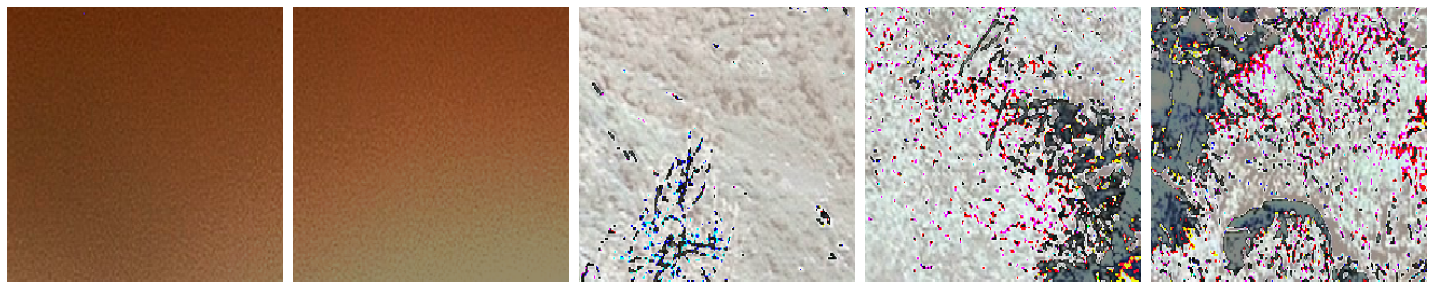

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
test_imags, test_labels = next(testing_generator)
plotImages(test_imags)
print(test_labels)

In [22]:
predictions = model.predict(x=testing_generator, verbose=0)

In [23]:
np.round(predictions)[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

#### Model Evaluation

In [24]:
cm = confusion_matrix(y_true=testing_generator.classes, y_pred=np.round(predictions))

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[129   3]
 [  3  48]]


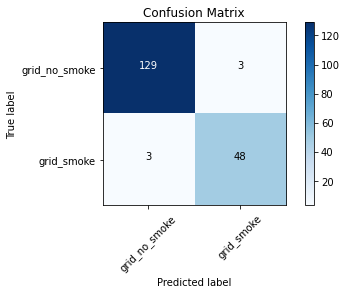

In [26]:
cm_plot_labels = [idx for idx in testing_generator.class_indices]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=False, title='Confusion Matrix')

#### Visualize Filters and Feature Maps in Convolutional Neural Networks

https://github.com/arshren/Feature-Visualization/blob/master/Feature%20Visualization.ipynb

conv2d (3, 3, 3, 32)
32


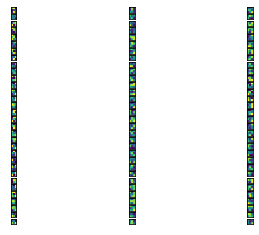

conv2d_1 (3, 3, 32, 32)
32


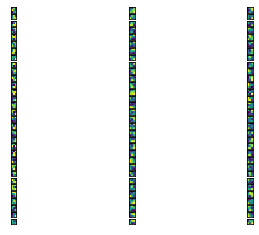

conv2d_2 (3, 3, 32, 64)
64


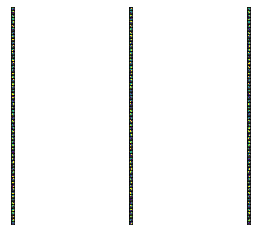

In [27]:
# Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        # if the layer is a convolutional layer, then extract the weights and bias values
        weights, bias = layer.get_weights()
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(layer.name, filters.shape)
        
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        # 3 because RGB
        print(filters.shape[3])
        filter_cnt=1
        
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

#### Visualizing feature maps or activation maps generated in a CNN

Feature maps are an intermediate representation for all layers after the first layer.

They are generated by applying Filters or Feature detectors to the input image or the feature map output of the prior layers. Feature map visualization will provide insight into the internal representations (i.e. prominent features) for specific input for each of the Convolutional layers in the model.

(1, 127, 127, 32)
(1, 125, 125, 32)
(1, 62, 62, 32)
(1, 60, 60, 64)
(1, 30, 30, 64)
(1, 57600)
(1, 64)
(1, 64)
(1, 1)
(1, 1)


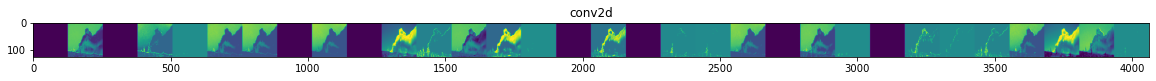

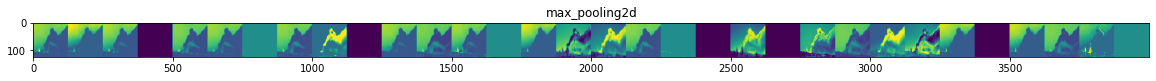

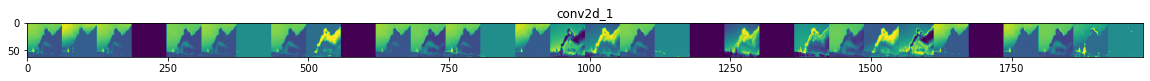

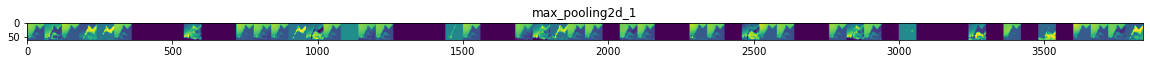

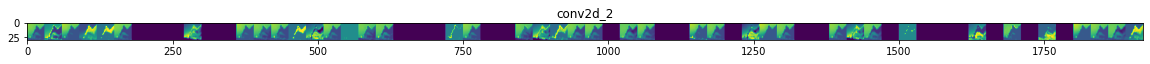

In [28]:
np.seterr(divide='ignore', invalid='ignore')

img_path='wildfire870.jpeg' #smoke

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(256, 256))  # this is a PIL image

x = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
    plt.savefig("./Images/feature_map", bbox_inches='tight', dpi=100);

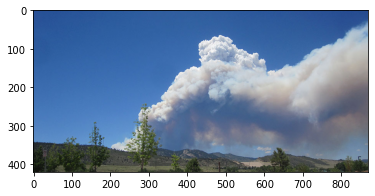

In [29]:
img = mpimg.imread('wildfire870.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [30]:
!pwd

/home/jupyter/capstone


In [ ]:
loaded_model = keras.models.load_model('/your_model_path')